In [8]:
%matplotlib inline

Let's look at an experiment where `e` is the event that there's an error matching assignment to exposure. In the ad example, this could include "the user doesn't sign on", resulting in $Z=1$, $X=0$, or possibly "the user sees a shared copy of the ad", resulting in $Z=0$, $X=1$. Notice that in each case, the event is unrelated to $Z$, so that both of these can also result in the right causal state for the wrong reason, i.e. $Z=0$, $X=0$ when the user doesn't sign on, and $Z=1$, $X=1$ when the user doesn't see the ad served to them, but instead sees a shared ad.

In [9]:
import pandas as pd
import numpy as np

p_e = 0.2
N = 10000

delta = np.random.uniform(0,1,size=N)


z = np.random.binomial(1., p=0.5, size=N)
e = np.random.binomial(1., p=p_e, size=N)
u = np.random.normal(size=N)
# The causal state takes the value $Z$ when there's no error (e==0), but is otherwise probabilistic and confounded.
x = (e==1)*np.random.binomial(1, p=1. / (1. + np.exp(-delta + u))) + (e==0)*z
y = u + delta*x + np.random.normal(size=N)

df = pd.DataFrame({"X": x, "Z": z, "E": e, "U": u, "Y": y})

It's easy to compare the naive estimator with the IV estimator.

In [10]:
def naive_effect(df):
    return df.groupby('X').mean()['Y'][1] - df.groupby('X').mean()['Y'][0]

def iv_effect(df):
    return np.cov(df['Y'], df['Z'])[0][1] / np.cov(df['X'], df['Z'])[0][1]

naive_effect(df), iv_effect(df)

(0.3817009335483647, 0.5306068928191995)

We see there's a fair amount of bias despite our large (N=10000) sample.


Now, let's see what happens with the term that can lead to high variance in the IV estimator when the instrument is weak. We can increase the error rate to weaken the effectiveness of treatment assignment, and study how the estimator changes as a result. 

First, we can see that the bias grows as the error rate increases, as we'd expect.

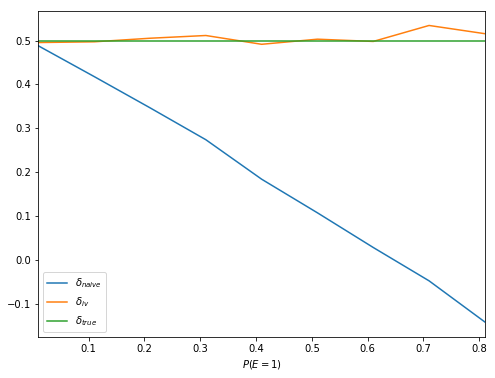

In [11]:

results = []
for p_e in np.arange(0.01, 0.9, 0.1):
    for _ in range(30):
        delta = np.random.uniform(0,1,size=N)

        z = np.random.binomial(1., p=0.5, size=N)
        e = np.random.binomial(1., p=p_e, size=N)
        u = np.random.normal(size=N)
        x = (e==1)*np.random.binomial(1, p=1. / (1. + np.exp(-delta + u))) + (e==0)*z
        y = u + delta*x + np.random.normal(size=N)

        df = pd.DataFrame({"X": x, "Z": z, "E": e, "U": u, "Y": y})
        naive = naive_effect(df)
        iv = iv_effect(df)
        results.append({'$P(E=1)$': p_e, '$\delta_{naive}$': naive, '$\delta_{iv}$': iv})

results = pd.DataFrame(results).groupby('$P(E=1)$').mean().reset_index()
results['$\delta_{true}$'] = delta.mean()
results.plot(x='$P(E=1)$', y=['$\delta_{naive}$', '$\delta_{iv}$', '$\delta_{true}$'], figsize=(8,6))

Now, let's look at what happens to the variance as the instrument gets weaker in a finite sample. We'll take N=1000 to get some clear results here.

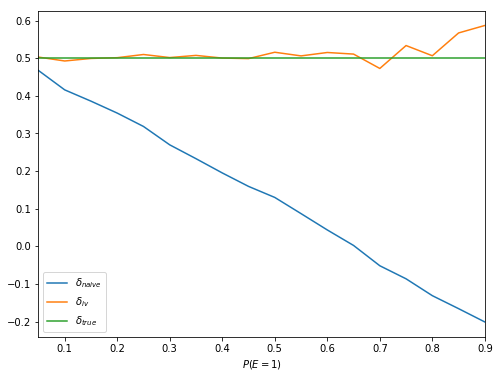

In [12]:
N = 1000
bootstrap_samples = 300

results = []
for p_e in np.arange(0.05, 0.95, 0.05):
    for _ in range(bootstrap_samples):
        delta = np.random.uniform(0,1,size=N)

        z = np.random.binomial(1., p=0.5, size=N)
        e = np.random.binomial(1., p=p_e, size=N)
        u = np.random.normal(size=N)
        x = (e==1)*np.random.binomial(1, p=1. / (1. + np.exp(-delta + u))) + (e==0)*z
        y = u + delta*x + np.random.normal(size=N)

        df = pd.DataFrame({"X": x, "Z": z, "E": e, "U": u, "Y": y})
        naive = naive_effect(df)
        iv = iv_effect(df)
        results.append({'$P(E=1)$': p_e, 
                        '$\delta_{naive}$': naive, 
                        '$\delta_{iv}$': iv, 
                        '$Corr(X, Z)$': np.corrcoef(df['X'], df['Z'])[0][1]})

df = pd.DataFrame(results).groupby('$P(E=1)$').mean()#.reset_index()
df['$\sigma_{\delta_{iv}}$'] = pd.DataFrame(results).groupby('$P(E=1)$').std()['$\delta_{iv}$']
df['$\delta_{true}$'] = delta.mean()
df.reset_index().plot(x='$P(E=1)$', y=['$\delta_{naive}$', '$\delta_{iv}$', '$\delta_{true}$'], figsize=(8,6))

We can see the IV estimator looks like it's staying unbiased as the instrument gets weaker, but it seems like it's getting stable as the error rate climbs. We know this should be due to the denominator of the estimator's error term, $Corr(X, Z)$, getting smaller, so we should just plot the estimates against that.

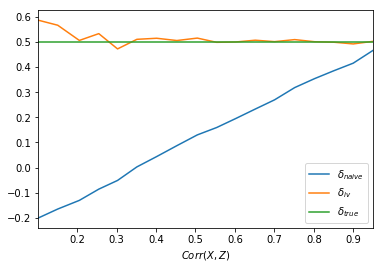

In [13]:
df.plot(x='$Corr(X, Z)$', y=['$\delta_{naive}$', '$\delta_{iv}$', '$\delta_{true}$'])

Again, we see the estimate appears unstable at small $Corr(X, Z)$. We know the error is mean zero, so we should check what's happening with the variance.

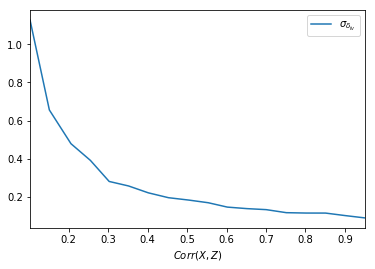

In [14]:
df.plot(x='$Corr(X, Z)$', y='$\sigma_{\delta_{iv}}$')

We see the variance of the IV estimator is blowing up as the instrument gets weaker. Even at N=1000, the standard error is the same size as the treatment effect ($\delta = 0.5$) at a pearson correlation as high as $Corr(X, Z) \simeq 0.2$. 

In real life, we don't have the luxury of bootstrapping our estimates over many data sets. Instead, we have to check the strength of our instrument by looking at $Corr(X, Z)$ and making sure the correlation is strong.